# Robustness to Execution Perturbations

This notebook evaluates the scheduler's ability to recover from unexpected changes. Two perturbation types are applied during execution:

* **Gate injection** – extra entangling operations are inserted while the circuit is already running.
* **Cost corruption** – cost model coefficients are perturbed to trigger re-planning.

For each magnitude we perform multiple repetitions, measuring the time to recover and the runtime overhead. Timelines highlight when re-planning occurs and a table summarises recovery statistics.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from quasar.circuit import Gate
from quasar.scheduler import Scheduler
from quasar.planner import Planner
from quasar.cost import Backend
from benchmarks import circuits

plt.rcParams['figure.dpi'] = 120

_circuit_factories = {
    'ghz': lambda: circuits.ghz_circuit(5),
    'grover': lambda: circuits.grover_circuit(5),
}


In [2]:
# Baseline runtime and memory

def measure_baseline(circuit_fn, backend_hint=None):
    sched = Scheduler(planner=Planner(), quick_max_gates=0)
    _, cost = sched.run(circuit_fn(), instrument=True, backend=backend_hint)
    return cost.time, cost.memory

baselines = {
    name: measure_baseline(fn, backend_hint=Backend.TABLEAU if name == 'ghz' else None)
    for name, fn in _circuit_factories.items()
}
baselines


{'ghz': (8.552599865652155e-05, 2209.0),
 'grover': (0.022467173001132323, 98416.0)}

In [3]:
# Perturbation helpers

def run_gate_perturbation(circuit_fn, baseline, magnitude, repetitions=5, *, enforce_stim=False, circuit_name=''):
    records = []
    for _ in range(repetitions):
        circuit = circuit_fn()
        scheduler = Scheduler(planner=Planner(), quick_max_gates=0)
        timeline = []
        info = {}
        step_idx = {'i': 0}
        peak_memory = 0.0

        def monitor(step, observed, est):
            nonlocal peak_memory
            now = time.perf_counter() - start
            start_t = timeline[-1]['end'] if timeline else 0.0
            timeline.append({
                'step': step_idx['i'],
                'start': start_t,
                'end': now,
                'backend': step.backend.name,
                'memory': observed.memory,
            })
            peak_memory = max(peak_memory, observed.memory)
            step_idx['i'] += 1
            if 'trigger' not in info:
                circuit.gates[step.end:step.end] = [Gate('T', [0])] * magnitude
                info['trigger'] = now
                return True
            return False

        start = time.perf_counter()
        scheduler.run(
            circuit,
            monitor=monitor,
            instrument=True,
            backend=Backend.TABLEAU if enforce_stim else None,
        )
        total = time.perf_counter() - start
        backend_switches = sum(
            timeline[i]['backend'] != timeline[i - 1]['backend']
            for i in range(1, len(timeline))
        )
        records.append({
            'circuit': circuit_name,
            'perturb': 'gate',
            'magnitude': magnitude,
            'total_time': total,
            'recovery_time': total - info['trigger'],
            'overhead': total - baseline[0],
            'peak_memory': peak_memory,
            'memory_overhead': peak_memory - baseline[1],
            'backend_switches': backend_switches,
            'timeline': timeline,
            'trigger_time': info['trigger'],
            'backends': [seg['backend'] for seg in timeline],
        })
    return records


def run_cost_perturbation(circuit_fn, baseline, factor, repetitions=5, *, enforce_stim=False, circuit_name=''):
    records = []
    for _ in range(repetitions):
        circuit = circuit_fn()
        scheduler = Scheduler(planner=Planner(), quick_max_gates=0)
        scheduler.planner.estimator.coeff['sv_gate_1q'] *= factor
        scheduler.planner.estimator.coeff['sv_gate_2q'] *= factor
        timeline = []
        step_idx = {'i': 0}
        peak_memory = 0.0

        def monitor(step, observed, est):
            nonlocal peak_memory
            now = time.perf_counter() - start
            start_t = timeline[-1]['end'] if timeline else 0.0
            timeline.append({
                'step': step_idx['i'],
                'start': start_t,
                'end': now,
                'backend': step.backend.name,
                'memory': observed.memory,
            })
            peak_memory = max(peak_memory, observed.memory)
            step_idx['i'] += 1
            return False

        start = time.perf_counter()
        scheduler.run(
            circuit,
            monitor=monitor,
            instrument=True,
            backend=Backend.TABLEAU if enforce_stim else None,
        )
        total = time.perf_counter() - start
        trigger = timeline[0]['end'] if timeline else 0.0
        backend_switches = sum(
            timeline[i]['backend'] != timeline[i - 1]['backend']
            for i in range(1, len(timeline))
        )
        records.append({
            'circuit': circuit_name,
            'perturb': 'cost',
            'magnitude': factor,
            'total_time': total,
            'recovery_time': total - trigger,
            'overhead': total - baseline[0],
            'peak_memory': peak_memory,
            'memory_overhead': peak_memory - baseline[1],
            'backend_switches': backend_switches,
            'timeline': timeline,
            'trigger_time': trigger,
            'backends': [seg['backend'] for seg in timeline],
        })
    return records


In [4]:
# Run experiments

repetitions = 5

gate_magnitudes = [1, 2, 3]
cost_magnitudes = [1e-6, 1e-7, 1e-8]

records = []
for name, fn in _circuit_factories.items():
    baseline = baselines[name]
    enforce = name == 'ghz'
    for m in gate_magnitudes:
        records.extend(run_gate_perturbation(fn, baseline, m, repetitions, enforce_stim=enforce, circuit_name=name))
    for f in cost_magnitudes:
        records.extend(run_cost_perturbation(fn, baseline, f, repetitions, enforce_stim=enforce, circuit_name=name))

results = pd.DataFrame(records)
results.head()


,circuit,perturb,magnitude,total_time,recovery_time,overhead,peak_memory,memory_overhead,backend_switches,timeline,trigger_time,backends
0,ghz,gate,1.0,0.000348,0.000071,0.000263,604.0,-1605.0,0,"[{'step': 0, 'start': 0.0, 'end': 0.0002770329...",0.000277,[TABLEAU]
1,ghz,gate,1.0,0.000217,0.000066,0.000131,604.0,-1605.0,0,"[{'step': 0, 'start': 0.0, 'end': 0.0001505199...",0.000151,[TABLEAU]
2,ghz,gate,1.0,0.000222,0.000063,0.000136,604.0,-1605.0,0,"[{'step': 0, 'start': 0.0, 'end': 0.0001584700...",0.000158,[TABLEAU]
3,ghz,gate,1.0,0.000193,0.000063,0.000108,604.0,-1605.0,0,"[{'step': 0, 'start': 0.0, 'end': 0.0001302540...",0.000130,[TABLEAU]
4,ghz,gate,1.0,0.000190,0.000054,0.000105,604.0,-1605.0,0,"[{'step': 0, 'start': 0.0, 'end': 0.0001367989...",0.000137,[TABLEAU]


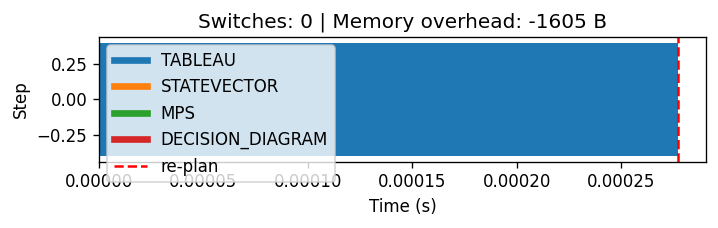

In [5]:
# Timeline plot for a representative run

sample = results[(results['perturb']=='gate') & (results['magnitude']==gate_magnitudes[0]) & (results['circuit']=='ghz')].iloc[0]
fig, ax = plt.subplots(figsize=(6, 2))
backend_colors = {'TABLEAU': 'tab:blue', 'STATEVECTOR': 'tab:orange', 'MPS': 'tab:green', 'DECISION_DIAGRAM': 'tab:red'}
for seg in sample['timeline']:
    ax.barh(seg['step'], seg['end']-seg['start'], left=seg['start'], color=backend_colors.get(seg['backend'], 'gray'))
ax.axvline(sample['trigger_time'], color='red', linestyle='--', label='re-plan')
handles = [plt.Line2D([0], [0], color=c, lw=4, label=b) for b, c in backend_colors.items()]
handles.append(plt.Line2D([0], [0], color='red', linestyle='--', label='re-plan'))
ax.legend(handles=handles)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Step')
ax.set_title("Switches: {0} | Memory overhead: {1:.0f} B".format(sample['backend_switches'], sample['memory_overhead']))
plt.tight_layout()
plt.show()


In [6]:
# Summary table of recovery metrics

metrics = results.groupby(['circuit', 'perturb', 'magnitude']).agg(
    recovery_mean=('recovery_time', 'mean'),
    recovery_std=('recovery_time', 'std'),
    overhead_mean=('overhead', 'mean'),
    overhead_std=('overhead', 'std'),
    memory_overhead_mean=('memory_overhead', 'mean'),
    memory_overhead_std=('memory_overhead', 'std'),
    backend_switches_mean=('backend_switches', 'mean'),
).reset_index()
metrics


,circuit,perturb,magnitude,recovery_mean,recovery_std,overhead_mean,overhead_std,memory_overhead_mean,memory_overhead_std,backend_switches_mean
0,ghz,cost,1.000000e-08,0.000042,0.000001,0.000093,0.000015,-1605.0,0.000000,0.0
1,ghz,cost,1.000000e-07,0.000047,0.000010,0.000102,0.000016,-1605.0,0.000000,0.0
2,ghz,cost,1.000000e-06,0.000044,0.000002,0.000100,0.000011,-1605.0,0.000000,0.0
3,ghz,gate,1.000000e+00,0.000063,0.000006,0.000149,0.000065,-1605.0,0.000000,0.0
4,ghz,gate,2.000000e+00,0.000055,0.000006,0.000116,0.000011,-1605.0,0.000000,0.0
5,ghz,gate,3.000000e+00,0.000055,0.000008,0.000107,0.000015,-1605.0,0.000000,0.0
6,grover,cost,1.000000e-08,0.014725,0.001274,1.718385,0.101387,-59593.6,1016.638972,0.0
7,grover,cost,1.000000e-07,0.013282,0.000908,1.593313,0.016581,-62729.6,1122.771036,0.0
8,grover,cost,1.000000e-06,0.012890,0.000542,1.586660,0.050170,-60816.8,1249.898076,0.0
9,grover,gate,1.000000e+00,0.012896,0.000457,1.571879,0.017986,-60137.6,1227.527922,0.0


In [7]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [8]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple)) and not isinstance(v, pd.DataFrame)
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import time\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\nfrom quasar.circuit import Gate\nfrom quasar.scheduler import Scheduler\nfrom quasar.planner import Planner\nfrom quasar.cost import Backend\nfrom benchmarks import circuits\n\nplt.rcParams['figure.dpi'] = 120\n\n_circuit_factories = {\n    'ghz': lambda: circuits.ghz_circuit(5),\n    'grover': lambda: circuits.grover_circuit(5),\n}",
    "# Baseline runtime and memory\n\ndef measure_baseline(circuit_fn, backend_hint=None):\n    sched = Scheduler(planner=Planner(), quick_max_gates=0)\n    _, cost = sched.run(circuit_fn(), instrument=True, backend=backend_hint)\n    return cost.time, cost.memory\n\nbaselines = {\n    name: measure_baseline(fn, backend_hint=Backend.TABLEAU if name == 'ghz' else None)\n    for name, fn in _circuit_factories.items()\n}\nbaselines",
    "# Perturbation helpers\n\ndef run_gate_perturbation(circuit_fn, baseline, magnitude, repetitions=5, *, enforc